# DSP Audio Disturbance Analysis
## 1. Audio Acquisition
This section captures raw audio from the serial interface and saves it as a 24-bit WAV file. This block is executed once; subsequent analysis uses the saved file.

In [ ]:
import serial
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

#Config
PORT = 'COM10'
BAUDRATE = 1000000
SAMPLINGRATE = 24000 #24kHz
DURATION = 5 #In seconds
BYTESPERSAMPLE = 4 #32-bit per sample
SAMPLESAMOUNT = SAMPLINGRATE * DURATION
BYTESNEEDED = SAMPLESAMOUNT * BYTESPERSAMPLE

#Open serial port
serialPort = serial.Serial(PORT, BAUDRATE, timeout=1)

print(f"Capturing {DURATION} sec of audio ({SAMPLESAMOUNT} samples)...")

#Read exact number of bytes
data = bytearray()
while len(data) < BYTESNEEDED:
    chunk = serialPort.read(BYTESNEEDED - len(data))
    if chunk:
        data.extend(chunk)

serialPort.close() #Now that we have the data, we can close the serialport again
print(f"Read {len(data)} bytes from serial")

#Convert raw audio data into data suitable for wav files
array32Bit = np.frombuffer(data, dtype='<i4') #Convert 32-bit little-endian words
array24Bit = (array32Bit >> 8).astype(np.int32) #Extract top 24 bits (MSB-aligned)
scaledAudio = array24Bit / float(2**23)

#Save as 24-bit .wav file
sf.write('audio/capture.wav', scaledAudio, SAMPLINGRATE, subtype='PCM_24')
print("Saved capture.wav")

plt.plot(scaledAudio[:1000])
plt.title("Waveform (first 1000 samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

## 2. Load Recorded Audio
This section loads the saved audio for analysis

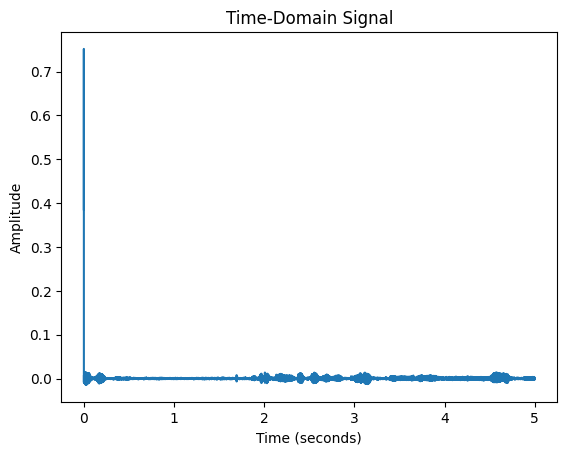

In [10]:
audioSignal, samplingRate = sf.read('audio/capture.wav')
samplesAmount = len(audioSignal)
timeAxis = np.arange(samplesAmount) / samplingRate

plt.plot(timeAxis, audioSignal)
plt.title("Time-Domain Signal")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

## 3. Discrete Fourier Transform (DFT)
### Theory
The DFT formulas are:

$$
A_k = \frac{1}{N} \sum_{n=0}^{N-1} x[n] e^{-j k \frac{2\pi}{N} n}
$$

$$
x[n] = \sum_{k=0}^{N-1} A_k e^{j k \frac{2\pi}{N} n}
$$

Here $x[n]$ is the time-domain signal, $A_k$ are the frequency coefficients, $N$ is the number of samples, $n$ indexes time, and $k$ indexes frequency. This is implemented manually below.

In [ ]:
signalLength = samplesAmount

#Arrays to store the real and imaginary parts of each frequency bin
realPart = np.zeros(signalLength)
imaginaryPart = np.zeros(signalLength)

#Calculate DFT: outer loop over frequency bins (k), inner loop over time samples (n)
for frequencyIndex in range(signalLength):  #Corresponds to k in A_k formula
    realSum = 0.0
    imaginarySum = 0.0
    for timeIndex in range(signalLength):   #Corresponds to n in A_k formula
        angle = 2 * np.pi * frequencyIndex * timeIndex / signalLength
        
        #Real and imaginary parts of e^{-j*angle} multiplied by x[n]
        realSum += audioSignal[timeIndex] * np.cos(angle)      #Re(x[n] * e^{-j 2πkn/N})
        imaginarySum -= audioSignal[timeIndex] * np.sin(angle) #Im(x[n] * e^{-j 2πkn/N})
    
    realPart[frequencyIndex] = realSum
    imaginaryPart[frequencyIndex] = imaginarySum

#Compute magnitude spectrum: |A_k| = sqrt(Re^2 + Im^2)
magnitudeSpectrum = np.sqrt(realPart**2 + imaginaryPart**2)

#Frequency axis in Hz
frequencyAxis = np.arange(signalLength) * samplingRate / signalLength

#Plot only the first half, because the DFT of a signal is symmetric
plt.plot(frequencyAxis[:signalLength//2], magnitudeSpectrum[:signalLength//2])
plt.title("Magnitude Spectrum (Manual DFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()